In [64]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [65]:
#load train and test files
train = pd.read_csv('train_BRCpofr.csv')
test = pd.read_csv('test_koRSKBP.csv')

In [66]:
print(train.shape, test.shape)

(89392, 12) (59595, 11)


In [67]:
train_copy = train.copy()

In [18]:
train

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736
...,...,...,...,...,...,...,...,...,...,...,...,...
89387,89388,Male,Rural,High School,More than 10L,0,6,0,More than 1,B,Platinum,95736
89388,89389,Male,Urban,Bachelor,5L-10L,1,0,3897,More than 1,A,Platinum,67596
89389,89390,Female,Urban,Bachelor,5L-10L,0,4,3363,More than 1,B,Platinum,114120
89390,89391,Female,Rural,High School,2L-5L,0,8,0,More than 1,B,Platinum,71772


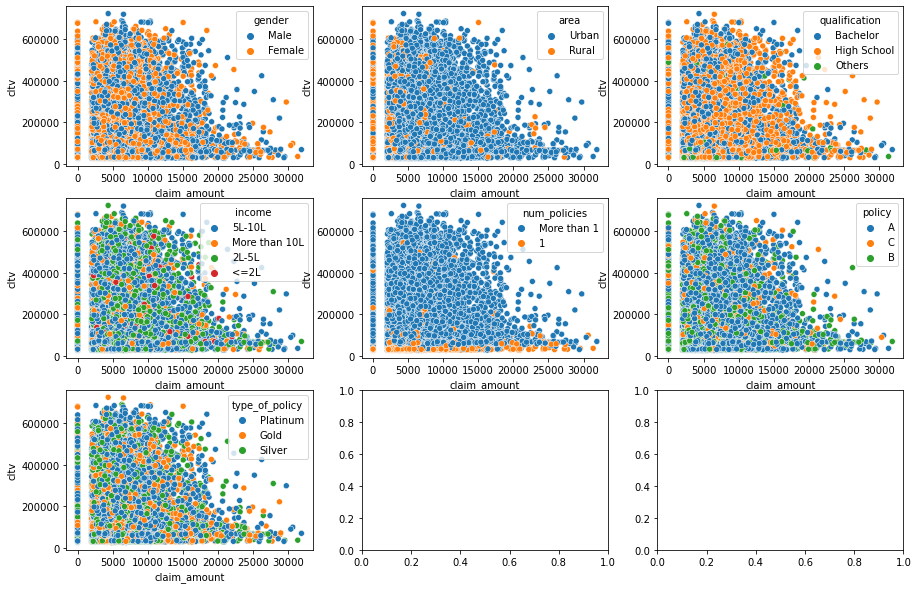

In [81]:
fig,axes = plt.subplots(3,3,figsize = (15,10))
axes = axes.ravel()
for i,col in enumerate(train.select_dtypes(include = ['object'])):
    sns.scatterplot(data = train, x = 'claim_amount', y = 'cltv', hue = col, ax = axes[i])
plt.show()
fig.savefig('figure1.png')

In [20]:
train.columns

Index(['id', 'gender', 'area', 'qualification', 'income', 'marital_status',
       'vintage', 'claim_amount', 'num_policies', 'policy', 'type_of_policy',
       'cltv'],
      dtype='object')

In [21]:
train = pd.get_dummies(train, drop_first = True)

In [22]:
test  = pd.get_dummies(test, drop_first = True)

In [23]:
train.columns = train.columns.str.replace('[','').str.replace(']','').str.replace('<','')
test.columns = test.columns.str.replace('[','').str.replace(']','').str.replace('<','')

In [24]:
train.set_index('id', inplace = True)
test.set_index('id', inplace = True)

In [25]:
train_zero = train[train.claim_amount == 0]
train_non_zero = train[train.claim_amount != 0]
test_zero = test[test.claim_amount == 0]
test_non_zero = test[test.claim_amount != 0]

In [26]:
train_zero_features = train_zero.drop(['cltv'], axis = 'columns')
train_non_zero_features = train_non_zero.drop(['cltv'], axis = 'columns')
test_zero_features = test_zero.copy()
test_non_zero_features = test_non_zero.copy()
train_zero_target = train_zero['cltv'].copy()
train_non_zero_target = train_non_zero['cltv'].copy()

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor

In [28]:
gbr_zero = GradientBoostingRegressor(n_estimators= 200, learning_rate= 0.05)
gbr_non_zero = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05)
xgbrf_zero = XGBRFRegressor(n_estimators = 500, learning_rate= 1)
xgbrf_non_zero = XGBRFRegressor(n_estimators = 500, learning_rate= 1)
lgbm_zero = LGBMRegressor(n_estimators= 50, learning_rate= 0.1)
lgbm_non_zero = LGBMRegressor(n_estimators= 50, learning_rate= 0.1)

In [29]:
gbr_zero.fit(train_zero_features, train_zero_target)
# zero_predictions = gbr_zero.predict(test_zero_features)
gbr_non_zero.fit(train_non_zero_features,train_non_zero_target)
# non_zero_predictions =gbr_non_zero.predict(test_non_zero_features)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=200)

In [31]:
train_zero['cltv_pred'] = gbr_zero.predict(train_zero_features)
train_non_zero['cltv_pred'] = gbr_non_zero.predict(train_non_zero_features)

In [34]:
gbr_prediction_df = pd.concat([train_zero, train_non_zero], axis = 'rows').sort_index()

In [36]:
gbr_prediction_df['abs'] = np.abs(gbr_prediction_df.cltv - gbr_prediction_df.cltv_pred)

<AxesSubplot:xlabel='abs', ylabel='Count'>

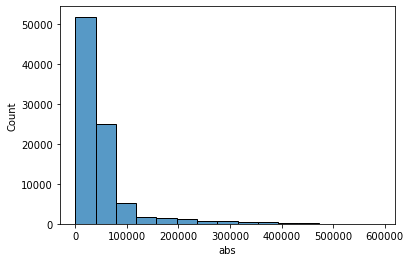

In [43]:
sns.histplot(gbr_prediction_df['abs'], bins = 15)

In [95]:
outlier_index = gbr_prediction_df[gbr_prediction_df['abs'] > 100000].index
print(len(outlier_index))

8392


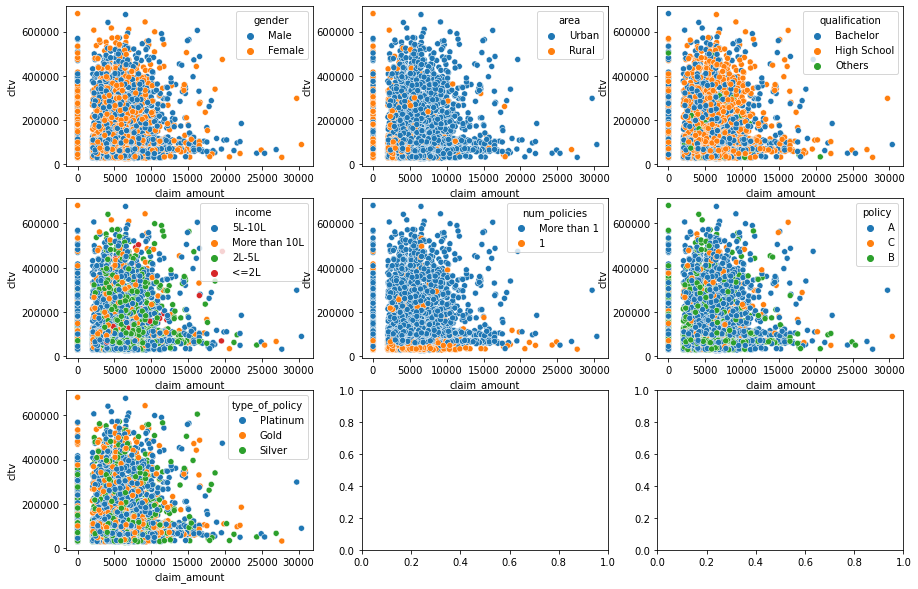

In [82]:

fig, axes = plt.subplots(3,3, figsize = (15,10))
axes = axes.ravel()
for i,col in enumerate(train_copy.select_dtypes(include = ['object'])):
    sns.scatterplot(data = train_copy.loc[outlier_index], x = 'claim_amount',y ='cltv', hue = col, ax = axes[i])
plt.show()
fig.savefig('figure2.png')

In [71]:
xgbrf_zero.fit(train_zero_features, train_zero_target)
xgbrf_non_zero.fit(train_non_zero_features,train_non_zero_target)


train_zero['cltv_pred'] = xgbrf_zero.predict(train_zero_features)
train_non_zero['cltv_pred'] = xgbrf_non_zero.predict(train_non_zero_features)

In [72]:
xgbrf_prediction_df = pd.concat([train_zero, train_non_zero], axis = 'rows').sort_index()
xgbrf_prediction_df['abs'] = np.abs(xgbrf_prediction_df.cltv - xgbrf_prediction_df.cltv_pred)

<AxesSubplot:xlabel='abs', ylabel='Count'>

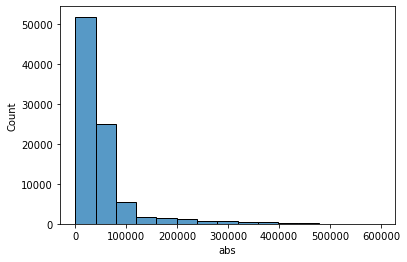

In [73]:
sns.histplot(xgbrf_prediction_df['abs'], bins = 15)

In [94]:
outlier_index = xgbrf_prediction_df[xgbrf_prediction_df['abs'] > 100000].index
print(len(outlier_index))

8335


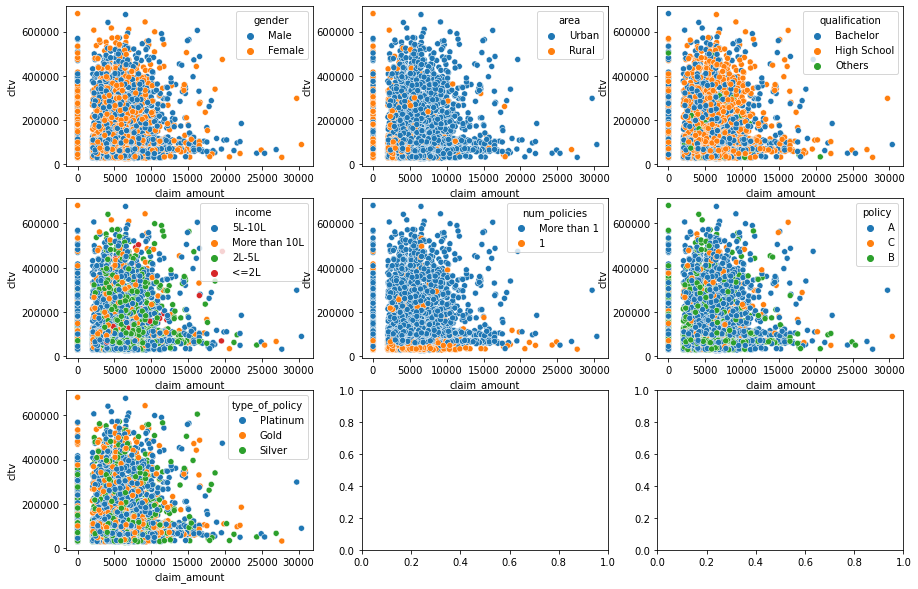

In [90]:
fig, axes = plt.subplots(3,3, figsize = (15,10))
axes = axes.ravel()
for i,col in enumerate(train_copy.select_dtypes(include = ['object'])):
    sns.scatterplot(data = train_copy.loc[outlier_index], x = 'claim_amount',y ='cltv', hue = col, ax = axes[i])
plt.show()
fig.savefig('figure3.png')

In [76]:
lgbm_zero.fit(train_zero_features, train_zero_target)
lgbm_non_zero.fit(train_non_zero_features,train_non_zero_target)
train_zero['cltv_pred'] = lgbm_zero.predict(train_zero_features)
train_non_zero['cltv_pred'] =lgbm_non_zero.predict(train_non_zero_features)

In [77]:
lgbm_prediction_df = pd.concat([train_zero, train_non_zero], axis = 'rows').sort_index()
lgbm_prediction_df['abs'] = np.abs(lgbm_prediction_df.cltv - lgbm_prediction_df.cltv_pred)

<AxesSubplot:xlabel='abs', ylabel='Count'>

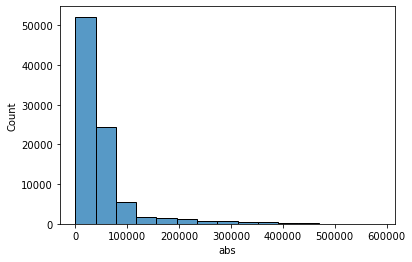

In [78]:
sns.histplot(lgbm_prediction_df['abs'], bins = 15)

In [93]:
outlier_index = lgbm_prediction_df[lgbm_prediction_df['abs'] > 100000].index
print(len(outlier_index))

8459


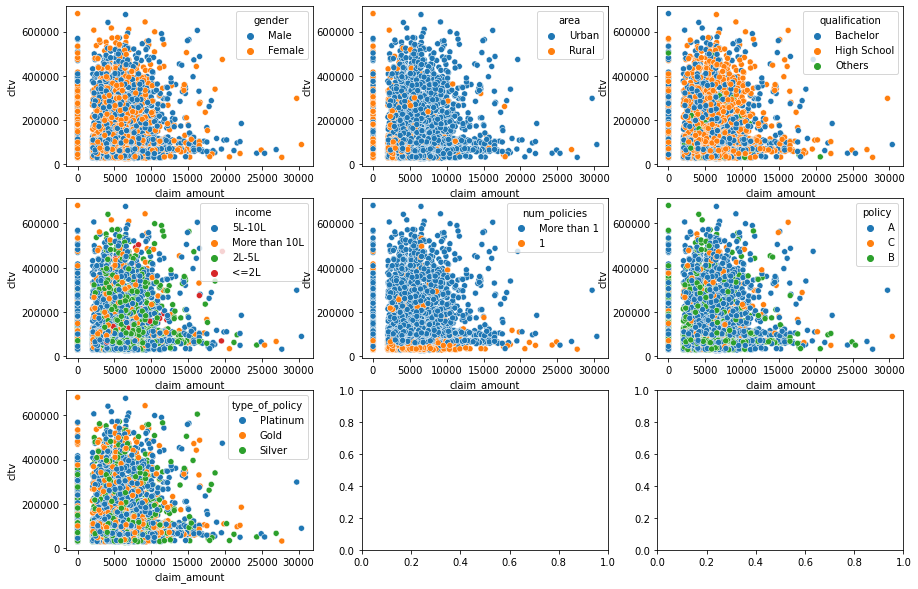

In [83]:
fig, axes = plt.subplots(3,3, figsize = (15,10))
axes = axes.ravel()
for i,col in enumerate(train_copy.select_dtypes(include = ['object'])):
    sns.scatterplot(data = train_copy.loc[outlier_index], x = 'claim_amount',y ='cltv', hue = col, ax = axes[i])
plt.show()
fig.savefig('figure4.png')

In [ ]:
from IPython.display import Image
Image(filename='figure1.png')

In [84]:
from IPython.display import Image

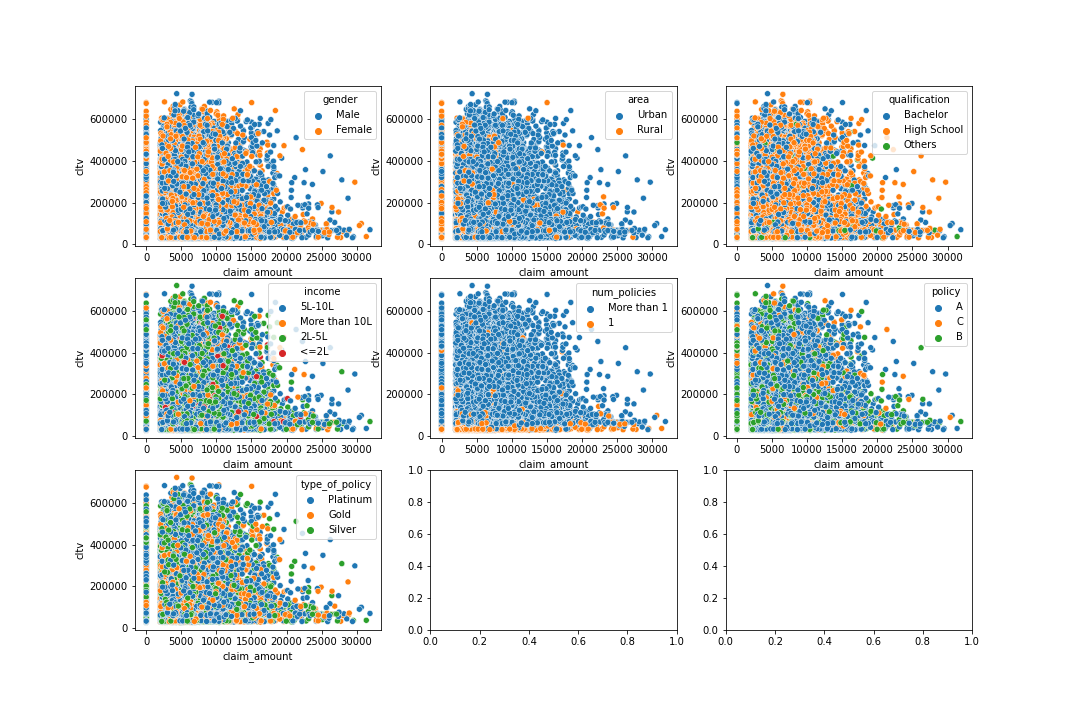

In [85]:
Image('figure1.png')

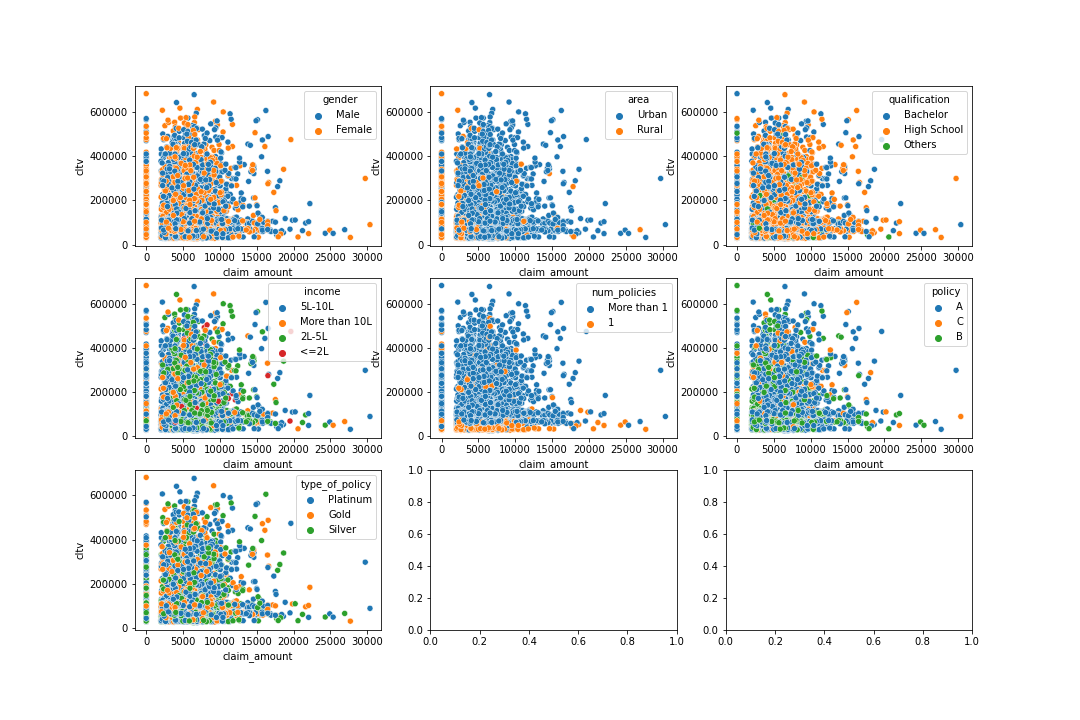

In [88]:
Image('figure2.png')

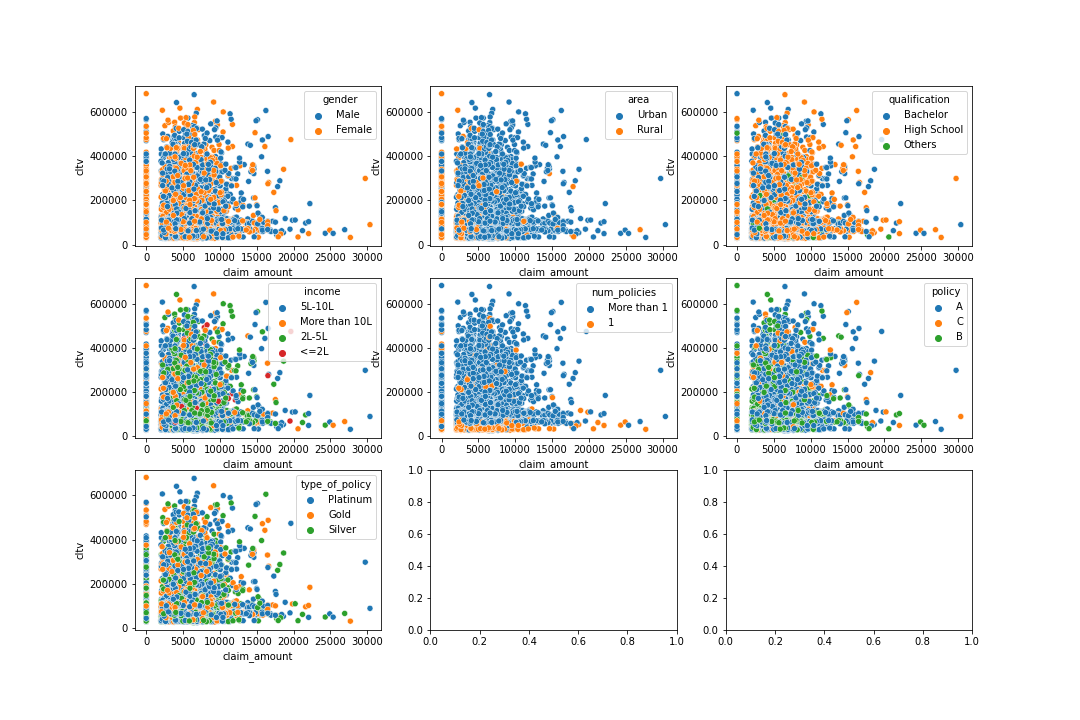

In [91]:
Image('figure3.png')

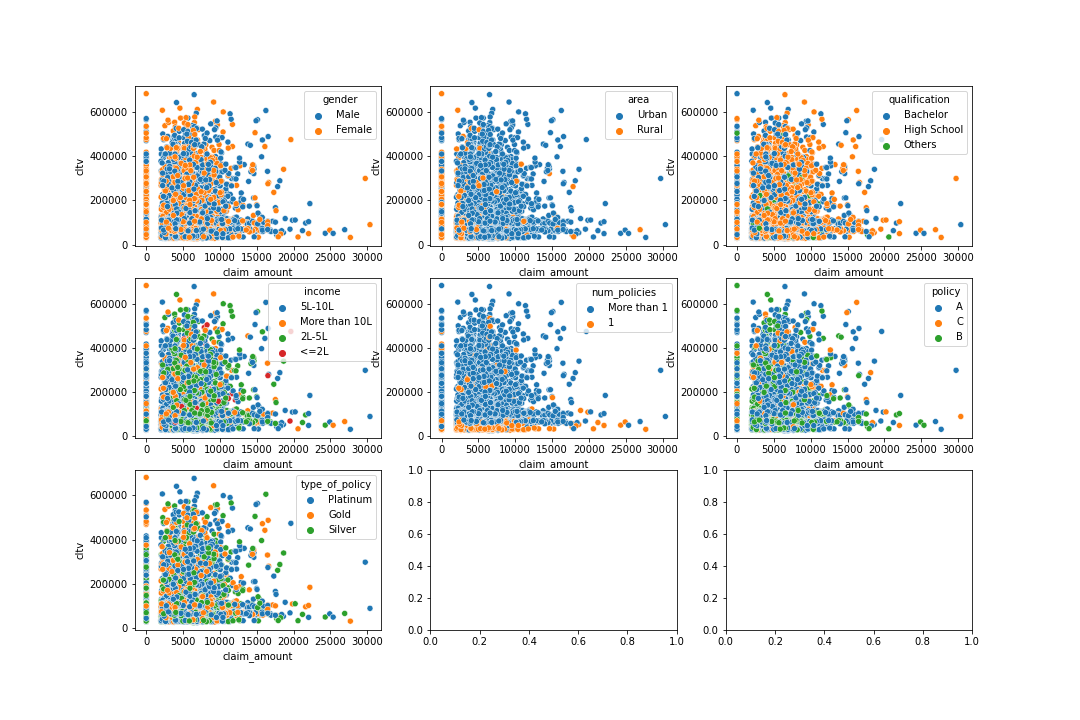

In [92]:
Image('figure4.png')

In [98]:
Arr=[1,2,3,4,5]

In [99]:
list(reversed(Arr))

[5, 4, 3, 2, 1]

In [100]:
sorted(Arr ,reverse=True)

[5, 4, 3, 2, 1]

In [101]:
order_total=[399,100,2939]
try:
    print(order_total[3])
except IndexError:
    print("Invalid Index")
except ValueError:
    print("Invalid Value")

Invalid Index


In [103]:
def rf():
    li ={4,3,3}
    print(li)

In [104]:
rf()

{3, 4}


In [105]:
a=((1,2,3),('a','b','c'),(1969,1995,1991))

In [106]:
print(type(a[1][3]))

IndexError: tuple index out of range

In [79]:
# test_zero['cltv'] = zero_predictions
# test_non_zero['cltv'] = non_zero_predictions

In [80]:
# submission = pd.concat([test_zero, test_non_zero], axis = 'rows').sort_index()

In [81]:
# submission = submission.reset_index()[['id', 'cltv']]
# gbr = submission
# submission.to_csv('sub_kb_1.csv', index = False)

In [82]:
train_zero_features.columns

Index(['marital_status', 'vintage', 'claim_amount', 'gender_Male',
       'area_Urban', 'qualification_High School', 'qualification_Others',
       'income_5L-10L', 'income_=2L', 'income_More than 10L',
       'num_policies_More than 1', 'policy_B', 'policy_C',
       'type_of_policy_Platinum', 'type_of_policy_Silver'],
      dtype='object')

In [87]:
# xgbrf_zero.fit(train_zero_features, train_zero_target)
# zero_predictions = xgbrf_zero.predict(test_zero_features)
# xgbrf_non_zero.fit(train_non_zero_features,train_non_zero_target)
# non_zero_predictions =xgbrf_non_zero.predict(test_non_zero_features)


# test_zero['cltv'] = zero_predictions
# test_non_zero['cltv'] = non_zero_predictions

# submission = pd.concat([test_zero, test_non_zero], axis = 'rows').sort_index()
# submission = submission.reset_index()[['id', 'cltv']]
# xgbrf = submission
# submission.to_csv('sub_kb_2.csv', index = False)

In [89]:
# lgbm_zero.fit(train_zero_features, train_zero_target)
# zero_predictions = lgbm_zero.predict(test_zero_features)
# lgbm_non_zero.fit(train_non_zero_features,train_non_zero_target)
# non_zero_predictions =lgbm_non_zero.predict(test_non_zero_features)

# test_zero['cltv'] = zero_predictions
# test_non_zero['cltv'] = non_zero_predictions

# submission = pd.concat([test_zero, test_non_zero], axis = 'rows').sort_index()
# submission = submission.reset_index()[['id', 'cltv']]
# lgbm = submission
# submission.to_csv('sub_kb_3.csv', index = False)

In [96]:
# gbr.rename(columns = {'cltv':'gbr_cltv'}, inplace = True)
# xgbrf.rename(columns = {'cltv':'xgbrf_cltv'}, inplace = True)
# lgbm.rename(columns = {'cltv':'lgbm_cltv'},inplace = True)

In [106]:
# final_df = pd.merge(pd.merge(gbr,xgbrf, on = ['id']), lgbm, on = ['id'])

In [107]:
# final_df

,id,gbr_cltv,xgbrf_cltv,lgbm_cltv
0,89393,95362.120398,91578.585938,91752.152035
1,89394,129334.220674,124740.664062,127705.169467
2,89395,92374.791266,91265.671875,91780.957715
3,89396,90608.262089,88411.734375,90773.532299
4,89397,131267.457108,135554.890625,127200.626727
...,...,...,...,...
59590,148983,46485.956949,45984.714844,46893.556657
59591,148984,52608.894642,47107.437500,46647.098130
59592,148985,108206.327372,104475.820312,105962.600060
59593,148986,112161.691206,110983.226562,111155.765788


# weighted Models